In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import random


In [ ]:
tickers = ['TLT', 'AGG', 'BND', 'LQD']
start_date = "2020-01-01"
end_date = "2025-01-01"

In [ ]:
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)

[*********************100%***********************]  4 of 4 completed


In [ ]:
if len(tickers) > 1:
    adj_close_data = data['Adj Close']
else:
    adj_close_data = data['Adj Close']

In [ ]:
returns = adj_close_data.pct_change().dropna()
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
risk_free_rate = 0.0425

In [ ]:
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
weights_record = np.zeros((num_portfolios, len(tickers)))

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record[i, :] = weights
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free_rate) / vol
    results[0, i] = ret
    results[1, i] = vol
    results[2, i] = sharpe

In [ ]:
print("Annualized Mean Returns:")
print(mean_returns)
print("\nAnnualized Covariance Matrix:")
print(cov_matrix)
print(f"\nRisk free rate: {risk_free_rate}")
print(f"\nData shape: {adj_close_data.shape}")
print(f"Date range: {adj_close_data.index[0]} to {adj_close_data.index[-1]}")
print(f"\nMonte Carlo Simulation Results:")
top_indices = np.argsort(results[2, :])[::-1][:5]
for i in top_indices:
    print(f"Portfolio {i}: Return = {results[0, i]:.2%}, Volatility = {results[1, i]:.2%}, Sharpe = {results[2, i]:.2f}")


Annualized Mean Returns:
Ticker
AGG   -0.002292
BND   -0.001064
LQD    0.003070
TLT   -0.048568
dtype: float64

Annualized Covariance Matrix:
Ticker       AGG       BND       LQD       TLT
Ticker                                        
AGG     0.004662  0.004570  0.006384  0.010092
BND     0.004570  0.004918  0.006782  0.009740
LQD     0.006384  0.006782  0.012462  0.013107
TLT     0.010092  0.009740  0.013107  0.032270

Risk-free rate: 0.0425

Data shape: (1258, 4)
Date range: 2020-01-02 00:00:00 to 2024-12-31 00:00:00

Monte Carlo Simulation Results (Top 5 Portfolios by Sharpe Ratio):
Portfolio 9137: Return = 0.25%, Volatility = 10.72%, Sharpe = -0.37
Portfolio 5047: Return = 0.10%, Volatility = 10.66%, Sharpe = -0.39
Portfolio 7557: Return = -0.03%, Volatility = 10.90%, Sharpe = -0.39
Portfolio 2124: Return = 0.10%, Volatility = 10.38%, Sharpe = -0.40
Portfolio 1417: Return = 0.14%, Volatility = 10.21%, Sharpe = -0.40


In [ ]:
def portfolio_performance(weights):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (ret - risk_free_rate) / vol
    return ret, vol, sharpe

def neg_sharpe(weights):
    return -portfolio_performance(weights)[2]

def cqns_score(weights, alpha=2):
    weights = np.array(weights)
    weights /= weights.sum()
    variance = np.dot(weights.T, np.dot(cov_matrix, weights))
    expected_return = np.dot(weights, mean_returns)
    return variance - (expected_return ** (2 + alpha))

In [ ]:
bounds = tuple((0, 1) for _ in tickers)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
initial_guess = len(tickers) * [1. / len(tickers)]

result = minimize(neg_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights_scipy = result.x
opt_return, opt_vol, opt_sharpe = portfolio_performance(opt_weights_scipy)

In [ ]:
def simulated_annealing_cqns(start_temp=100, cooling=0.99, iterations=5000):
    current_weights = np.random.dirichlet(np.ones(len(tickers)))
    best_weights = current_weights
    current_score = cqns_score(current_weights)
    best_score = current_score
    T = start_temp

    for _ in range(iterations):
        new_weights = current_weights + np.random.normal(0, 0.02, len(tickers))
        new_weights = np.abs(new_weights)
        new_weights /= np.sum(new_weights)
        new_score = cqns_score(new_weights)

        if new_score < best_score or np.exp((current_score - new_score) / T) > random.random():
            current_weights = new_weights
            current_score = new_score
            if new_score < best_score:
                best_score = new_score
                best_weights = new_weights

        T *= cooling

    return best_weights, best_score

opt_weights_sa, best_cqns = simulated_annealing_cqns()
opt_return_sa = np.dot(opt_weights_sa, mean_returns)
opt_vol_sa = np.sqrt(np.dot(opt_weights_sa.T, np.dot(cov_matrix, opt_weights_sa)))
opt_sharpe_sa = (opt_return_sa - risk_free_rate) / opt_vol_sa

In [ ]:
print("\nSharpe Ratio Optimization:")
for ticker, w in zip(tickers, opt_weights_scipy):
    print(f"{ticker}: {w:.2%}")
print(f"Return: {opt_return:.2%}, Volatility: {opt_vol:.2%}, Sharpe: {opt_sharpe:.2f}\n")

print("CQNS Optimization:")
for ticker, w in zip(tickers, opt_weights_sa):
    print(f"{ticker}: {w:.2%}")
print(f"Return: {opt_return_sa:.2%}, Volatility: {opt_vol_sa:.2%}, Sharpe: {opt_sharpe_sa:.2f}, CQNS Score: {best_cqns:.5f}")


Sharpe Ratio Optimization (SciPy SLSQP):
TLT: 0.00%
AGG: 0.00%
BND: 100.00%
LQD: 0.00%
Return: 0.31%, Volatility: 11.16%, Sharpe: -0.35

CQNS Optimization (Simulated Annealing):
TLT: 36.79%
AGG: 63.13%
BND: 0.01%
LQD: 0.06%
Return: -0.15%, Volatility: 6.88%, Sharpe: -0.64, CQNS Score: 0.00473


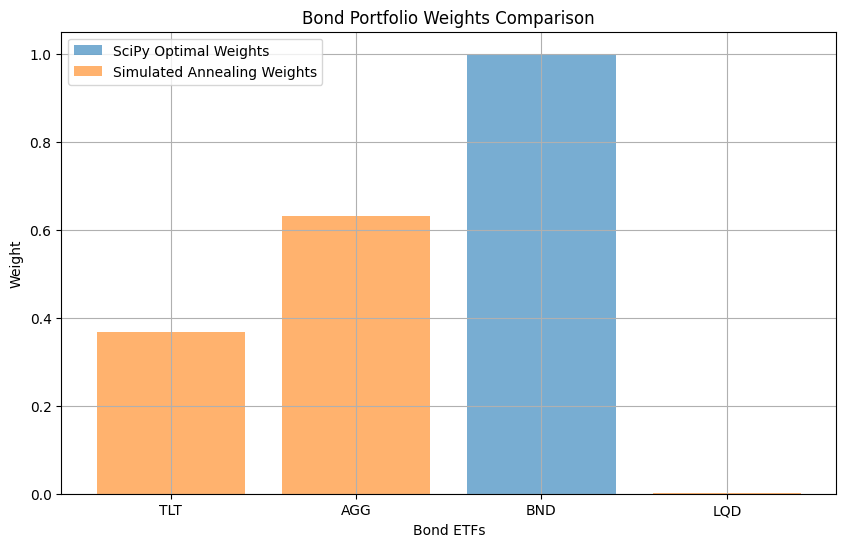

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, opt_weights_scipy, alpha=0.6, label='SciPy Optimal Weights')
plt.bar(tickers, opt_weights_sa, alpha=0.6, label='Simulated Annealing Weights')
plt.title("Bond Portfolio Weights Comparison")
plt.xlabel("Bond ETFs")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()

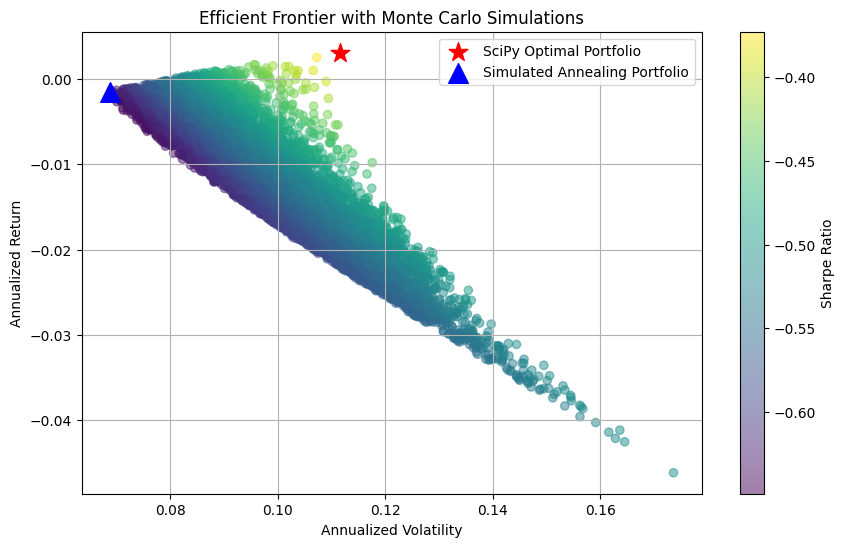

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', marker='o', alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_vol, opt_return, c='red', marker='*', s=200, label='SciPy Optimal Portfolio')
plt.scatter(opt_vol_sa, opt_return_sa, c='blue', marker='^', s=200, label='Simulated Annealing Portfolio')
plt.title("Efficient Frontier with Monte Carlo Simulations")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)

In [ ]:
chart_config = {
    "type": "scatter",
    "data": {
        "datasets": [
            {
                "label": "Monte Carlo Portfolios",
                "data": [{"x": results[1, i], "y": results[0, i]} for i in range(num_portfolios)],
                "backgroundColor": "rgba(75, 192, 192, 0.5)",
                "pointRadius": 3
            },
            {
                "label": "SciPy Optimal Portfolio",
                "data": [{"x": opt_vol, "y": opt_return}],
                "backgroundColor": "rgba(255, 99, 132, 1)",
                "pointRadius": 10,
                "pointStyle": "star"
            },
            {
                "label": "Simulated Annealing Portfolio",
                "data": [{"x": opt_vol_sa, "y": opt_return_sa}],
                "backgroundColor": "rgba(54, 162, 235, 1)",
                "pointRadius": 10,
                "pointStyle": "triangle"
            }
        ]
    },
    "options": {
        "scales": {
            "x": {
                "title": {"display": True, "text": "Annualized Volatility"},
                "type": "linear",
                "position": "bottom"
            },
            "y": {
                "title": {"display": True, "text": "Annualized Return"}
            }
        },
        "plugins": {
            "legend": {"display": True},
            "title": {"display": True, "text": "Efficient Frontier with Monte Carlo Simulations"}
        }
    }
}



In [ ]:
!git config --global user.name "DishaPatel9854"
!git config --global user.email "dishapatel9854@gmail.com"

In [ ]:
%cd /content
!git init

/content
hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
